# Writing Custom Datasets

A significant amount of the effort applied to developing machine learning algorithms is related to data preparation. PyTorch provides many tools to make data loading easy and hopefully, makes your code more readable. In this recipe, you will learn how to create a custom dataset leveraging the PyTorch dataset APIs. 

Please note, to run this tutorial, ensure the following packages are
installed:
-  ``scikit-image``: For image io and transforms
-  ``pandas``: For easier csv parsing

As a point of attribution, this recipe is based on the original tutorial from `Sasank Chilamkurthy <https://chsasank.github.io>` and was later edited by `Joe Spisak <https://github.com/jspisak>`.

### First let's import all of the needed libraries for this recipe

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## **The Dataset we'll use as a starting point**

The dataset we are going to deal with is that of facial pose. Overall, 68 different landmark points are annotated for each face.

As a next step, please download the dataset from `here <https://download.pytorch.org/tutorial/faces.zip>` so that the images are in a directory named 'data/faces/'.
     
     
**Note:** This dataset was actually generated by applying `dlib's pose estimation <https://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>` on images from the imagenet dataset containing the 'face' tag. 


In [2]:
!wget https://download.pytorch.org/tutorial/faces.zip
# !mkdir data/faces/
import zipfile
with zipfile.ZipFile("faces.zip","r") as zip_ref:
    zip_ref.extractall("/data/faces/")

%cd /data/faces/


--2020-03-26 05:03:17--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.181.40, 99.84.181.45, 99.84.181.3, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.181.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip.15’

faces.zip.15        100%[===================>]   5.51M  --.-KB/s    in 0.1s    

2020-03-26 05:03:17 (54.9 MB/s) - ‘faces.zip.15’ saved [5780252/5780252]

/data/faces


The dataset comes with a csv file with annotations which looks like this:

      image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
      0805personali01.jpg,27,83,27,98, ... 84,134
      1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

Let's quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [3]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))



Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


### Next let's write a simple helper function to show an image, its landmarks and use it to show a sample.

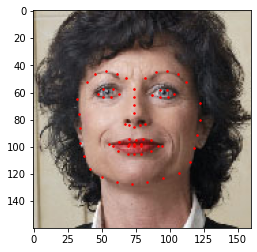

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

### Now lets talk about the PyTorch dataset class

 ``torch.utils.data.Dataset`` is an abstract class representing a
 dataset.
 Your custom dataset should inherit ``Dataset`` and override the following
 methods:

 -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
 -  ``__getitem__`` to support indexing such that ``dataset[i]`` can
    be used to get :math:`i`\ th sample

Let's create a dataset class for our face landmarks dataset. We will read the csv in ``__init__`` but leave the reading of images to ``__getitem__``. This is memory efficient because all the images are not stored in the memory at once but read as required.

Here we show a sample of our dataset in the forma of a dict ``{'image': image, 'landmarks': landmarks}``. Our dataset will take an optional argument ``transform`` so that any required processing can be applied on the sample. We will see the usefulness of ``transform`` in another recipe.


In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Iterating through data samples

Next let's instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

0 (324, 215, 3) (68, 2)


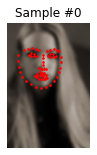

1 (500, 333, 3) (68, 2)


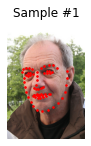

2 (250, 258, 3) (68, 2)


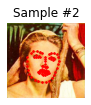

3 (434, 290, 3) (68, 2)


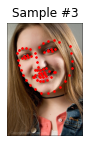

In [10]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Now that you've learned how to create a custom dataset with PyTorch, we recommend reading recipes on writing customer dataloaders and data transforms. See here:
<add link to Custom loader recipe>
<add link to Custom data transforms recipe>
